### 扩充数据集

In [1]:
import pandas as pd

# CSV文件路径列表
file_paths = [
    './dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 
    './dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 
    './dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    './dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv'
    ]

# 初始化空DataFrame用于存储所有筛选后的数据
all_filtered_data = pd.DataFrame()

for file_path in file_paths:
    # 读取CSV文件
    df = pd.read_csv(file_path, encoding='cp1252')
    
    # 筛选非'BENIGN'的数据
    filtered_df = df[df[' Label'] != 'BENIGN']

    if len(filtered_df) >= 18892:
        filtered_df = filtered_df.head(18892)
    
    # 将筛选后的数据添加到总数据集
    all_filtered_data = pd.concat([all_filtered_data, filtered_df], ignore_index=True)

# 保存合并后的数据到新的CSV文件，共 40000 条数据
all_filtered_data.to_csv('./dataset/my_abnormal_dataset.csv', index=False)

# 读取正常流量 CSV文件
df = pd.read_csv('./dataset/Monday-WorkingHours.pcap_ISCX.csv', encoding='cp1252')  

# 如果数据超过 40000 条，只保留前 40000 条
if len(df) > 40000:
    df = df.head(40000)

# 保存到新的CSV文件
df.to_csv('./dataset/my_normal_dataset.csv', index=False)  

### 数据预处理 

In [15]:
'''
    导入必要的库：
    __future__ 模块用于引入Python未来版本的特性，确保向后兼容性。
    pandas 和 numpy 用于数据处理。
    torch 用于后续的深度学习模型训练。
    train_test_split 用于分割数据集
    StandardScaler 用于特征标准化。
'''
from __future__ import absolute_import, division, print_function
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
'''
    读取异常和正常数据集。
    使用 cp1252 编码读取，可能是因为数据集中包含特殊字符。
'''
resampled_ab_df = pd.read_csv('./dataset/my_abnormal_dataset.csv', encoding='cp1252')
resampled_nor_df = pd.read_csv('./dataset/my_normal_dataset.csv', encoding='cp1252')

print("样本数量（resampled_ab_df）：", resampled_ab_df.shape[0])
print("样本数量（resampled_nor_df）：", resampled_nor_df.shape[0])

# 合并异常和正常数据集，并打印合并后的总样本数量。
df = pd.concat([resampled_nor_df, resampled_ab_df])
print("整合后的样本数量：", df.shape[0])

# 删除对模型训练不必要的列，例如IP地址、时间戳和流ID，这些特征可能对分类任务无关或可能引起过拟合。
# df = df.drop(columns=[' Source IP', ' Destination IP', ' Timestamp', ' Flow ID'])

# 检查并删除可能存在的多余索引列 Unnamed: 0，这通常在数据导出时无意中创建。
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

'''
    定义一个函数 label_transfer，用于将文本标签转换为二进制标签:
    非BENIGN（正常）标记为1（异常），BENIGN标记为0（正常）。
'''
def label_transfer(d):
    if d != 'BENIGN':
        return 1
    else:
        return 0
# 替换数据中的无限值为NaN，删除含有NaN的行，以确保数据的完整性。
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
# 将 Label 列的文本标签转换为二进制标签。
df[' Label'] = df[' Label'].apply(lambda x: label_transfer(x))
# 初始化 MinMaxScaler 对象，并对特征进行标准化处理，这有助于提高模型的训练效率和效果。
scaler = MinMaxScaler()
column_size = len(df.columns)
values = df.values[:, :column_size - 1]
scaler.fit(values)
values = scaler.transform(values)

# 从数据框中分离特征和目标变量。
targets = df.values[:, column_size - 1: column_size]
 
# 确保样本数量是10的倍数，以便能整齐地分组。
num_samples = len(values) // 10 * 10
# 初始化用于存放分组数据的数组。
grouped_data_x = np.zeros((num_samples // 10, 10, 78))
grouped_data_y = np.zeros(num_samples // 10)
 
# 将数据分为大小为10的小组，每组数据用于模型的一个输入实例。
for i in range(0, num_samples, 10):
    locs = np.arange(i, i + 10, 1)
    token_list = values[locs]
    grouped_data_x[int(i/10)] = token_list
    grouped_data_y[int(i/10)] = targets[i][0]

# 将数据拆分为训练集、交叉验证集（或验证集）、测试集
train_x, temp_x, train_y, temp_y = train_test_split(grouped_data_x, grouped_data_y, test_size=0.4, random_state=42)
valid_x, test_x, valid_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5, random_state=42)

# 转换为张量格式
train_X = torch.from_numpy(train_x).type(torch.FloatTensor)
valid_X = torch.from_numpy(valid_x).type(torch.FloatTensor)
test_X = torch.from_numpy(test_x).type(torch.FloatTensor)
train_Y = torch.from_numpy(train_y).type(torch.LongTensor)
valid_Y = torch.from_numpy(valid_y).type(torch.LongTensor)
test_Y = torch.from_numpy(test_y).type(torch.LongTensor)

# 转换张量为NumPy数组
train_X_np = train_X.numpy()
valid_X_np = valid_X.numpy()
test_X_np = test_X.numpy()
train_Y_np = train_Y.numpy()
valid_Y_np = valid_Y.numpy()
test_Y_np = test_Y.numpy()

# 将张量转换为DataFrame 
train_X_df = pd.DataFrame(train_X_np.reshape(-1, train_X_np.shape[2]))
valid_X_df = pd.DataFrame(valid_X_np.reshape(-1, valid_X_np.shape[2]))
test_X_df = pd.DataFrame(test_X_np.reshape(-1, test_X_np.shape[2]))
train_Y_df = pd.DataFrame(train_Y_np, columns=['Label'])
valid_Y_df = pd.DataFrame(valid_Y_np, columns=['Label'])
test_Y_df = pd.DataFrame(test_Y_np, columns=['Label'])

# 将处理好的数据保存为CSV文件，方便后续使用或分析。
train_X_df.to_csv('./dataset/my_train_X.csv', index=False)
valid_X_df.to_csv('./dataset/my_valid_X.csv', index=False)
test_X_df.to_csv('./dataset/my_test_X.csv', index=False)
train_Y_df.to_csv('./dataset/my_train_Y.csv', index=False)
valid_Y_df.to_csv('./dataset/my_valid_Y.csv', index=False)
test_Y_df.to_csv('./dataset/my_test_Y.csv', index=False)

样本数量（resampled_ab_df）： 40000
样本数量（resampled_nor_df）： 40000
整合后的样本数量： 80000


### 搭建深度学习模型

In [16]:
# Model structure

import math
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerClassifier(nn.Module):

  def __init__(self, ninp, nhead, nhid, nlayers, dropout):
    super(TransformerClassifier, self).__init__()
    self.model_type = 'Transformer'
      
    # 创建一个 Transformer 编码层，这里设置了输入维度 ninp，多头注意力的头数 nhead，隐藏层大小 nhid，以及 dropout 率。  
    encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout, batch_first=True)
      
    # 基于上面定义的编码层，创建一个 Transformer 编码器，包含 nlayers 层的 Transformer 编码层。  
    self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
      
    self.ninp = ninp
      
    # 定义一个 dropout 层，用于减少过拟合，这里设置了 30% 的 dropout 率。  
    self.dropout = nn.Dropout(0.3)
      
    '''
        使用列表推导式创建一系列的 2D 卷积层，用于提取序列的局部特征。
        这些卷积层都是从一个通道开始，输出 100 个通道，卷积核大小分别是 (3, ninp)，(4, ninp)，(5, ninp)。  
    '''
    self.convs = nn.ModuleList([nn.Conv2d(1, 100, (K, ninp)) for K in [3,4,5]])
      
    # 定义一个全连接层，用于将 Transformer 的输出映射到两个输出类别上。  
    self.classifier = nn.Linear(ninp, 2)
      
    # 定义另一个全连接层，用于处理卷积层输出的合并结果，其中 len([3,4,5]) * 100 表示所有卷积层输出特征的总数。
    self.fc1 = nn.Linear(len([3,4,5]) * 100, 2)
    self.init_weights()

  # 生成一个方形的自回归掩码，用于在Transformer中屏蔽未来位置的信息。  
  def generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

  def init_weights(self):
    initrange = 0.1
    self.classifier.bias.data.zero_()
    self.classifier.weight.data.uniform_(-initrange, initrange)

  def forward(self, src):
    src = src * math.sqrt(self.ninp) # 缩放输入
    x = self.transformer_encoder(src) # 应用 Transformer 编码器
    x = x.unsqueeze(1) # 增加一个维度，为卷积层准备
    x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs] # 应用卷积层和ReLU激活函数，然后移除多余的维度
    x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # 应用最大池化
    x = torch.cat(x, 1) # 在特征维度上拼接所有卷积层的输出
    x = self.dropout(x) # 应用 dropout
    logit = self.fc1(x) # 使用全连接层生成最终的特征输出
    return logit

  def predict(self, x):
    x = self.forward(x)
    # 应用 sigmoid 获取概率，然后选择最高概率的索引作为类别预测  
    return torch.argmax(torch.sigmoid(x), dim=1)

### 训练模型

In [18]:
import torch.optim

#Initialize the model
model = TransformerClassifier(len(df.columns) - 1, 6, 1024, 3, 0.5)
#Define loss criterion
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#Size of traning data batch

BATCH_SIZE = 512
#Number of epochs
epochs = 20
#List to store losses
train_losses = []
valid_losses = [] 
test_losses = []

for i in range(epochs):
  
  train_loss_total = 0
  valid_loss_total = 0  
  test_loss_total = 0

  permutation = torch.randperm(train_X.size()[0])
  for j in range(0, train_X.size()[0], BATCH_SIZE):

    #Clear the previous gradients
    optimizer.zero_grad()

    #Batch the data
    indices = permutation[j: j + BATCH_SIZE]
    batch_x, batch_y = train_X[indices], train_Y[indices]

    model.train()  
    train_y_pred = model.forward(batch_x)

    #Compute BCEWithLogitsLoss
    train_loss = criterion(train_y_pred, batch_y)
    train_loss_total += train_loss

    #Add loss to the list
    train_losses.append(train_loss.item())

    model.eval()
    valid_y_pred = model.forward(valid_X)  
    test_y_pred = model.forward(test_X)
    valid_loss = criterion(valid_y_pred, valid_Y) 
    valid_loss_total += valid_loss  
    test_loss = criterion(test_y_pred, test_Y)
    test_loss_total += test_loss  
    valid_losses.append(valid_loss.item())
    test_losses.append(test_loss.item())  
    
    train_loss.backward()
    optimizer.step()
    
  print(str(i) + 'th of ' + str(epochs) + ' Epoch' + " | TRAIN_LOSS:" + str(train_loss_total.data) + "| VALID-LOSS:" + str(valid_loss_total.data) +" | TEST-LOSS:" + str(test_loss_total.data))

0th of 20 Epoch | TRAIN_LOSS:tensor(6.9138)| VALID-LOSS:tensor(6.2885) | TEST-LOSS:tensor(6.2754)
1th of 20 Epoch | TRAIN_LOSS:tensor(2.1239)| VALID-LOSS:tensor(1.8862) | TEST-LOSS:tensor(1.9154)
2th of 20 Epoch | TRAIN_LOSS:tensor(1.3644)| VALID-LOSS:tensor(1.2174) | TEST-LOSS:tensor(1.2318)
3th of 20 Epoch | TRAIN_LOSS:tensor(0.6960)| VALID-LOSS:tensor(0.5835) | TEST-LOSS:tensor(0.6062)
4th of 20 Epoch | TRAIN_LOSS:tensor(0.4352)| VALID-LOSS:tensor(0.2987) | TEST-LOSS:tensor(0.3261)
5th of 20 Epoch | TRAIN_LOSS:tensor(0.2986)| VALID-LOSS:tensor(0.2737) | TEST-LOSS:tensor(0.3070)
6th of 20 Epoch | TRAIN_LOSS:tensor(0.2501)| VALID-LOSS:tensor(0.1703) | TEST-LOSS:tensor(0.1838)
7th of 20 Epoch | TRAIN_LOSS:tensor(0.1765)| VALID-LOSS:tensor(0.1324) | TEST-LOSS:tensor(0.1517)
8th of 20 Epoch | TRAIN_LOSS:tensor(0.1394)| VALID-LOSS:tensor(0.1155) | TEST-LOSS:tensor(0.1090)
9th of 20 Epoch | TRAIN_LOSS:tensor(0.1161)| VALID-LOSS:tensor(0.0948) | TEST-LOSS:tensor(0.1110)
10th of 20 Epoch | T

In [19]:
from sklearn import metrics

results = []
valid_results = []
# 进行训练并在测试集上进行评估
for i in range(0, len(test_X), 5):
    ret = model.predict(test_X[i:i+5])
    results.append(ret)  # 将预测结果添加到results列表中

# 同时对验证集进行评估
for i in range(0, len(valid_X), 5):
    ret = model.predict(valid_X[i:i+5])
    valid_results.append(ret)  # 将预测结果添加到valid_results列表中
 
# 检查测试结果列表是否为空
if results:
    dd = torch.cat(results)  # 合并所有测试预测结果
    if len(dd) == len(test_Y):
        print("测试集准确率:{:.10f}".format(metrics.accuracy_score(dd, test_Y)))
        print("测试集召回率:{:.10f}".format(metrics.recall_score(dd, test_Y, average='micro')))
    else:
        print("测试预测结果数量与标签数量不匹配")
else:
    print("测试结果列表为空")

# 检查验证结果列表是否为空
if valid_results:
    valid_dd = torch.cat(valid_results)  # 合并所有验证预测结果
    if len(valid_dd) == len(valid_Y):
        print("验证集准确率:{:.10f}".format(metrics.accuracy_score(valid_dd, valid_Y)))
        print("验证集召回率:{:.10f}".format(metrics.recall_score(valid_dd, valid_Y, average='micro')))
    else:
        print("验证预测结果数量与标签数量不匹配")
else:
    print("验证结果列表为空")

测试集准确率:0.9981238274
测试集召回率:0.9981238274
验证集准确率:0.9987492183
验证集召回率:0.9987492183


### 实验数据可视化

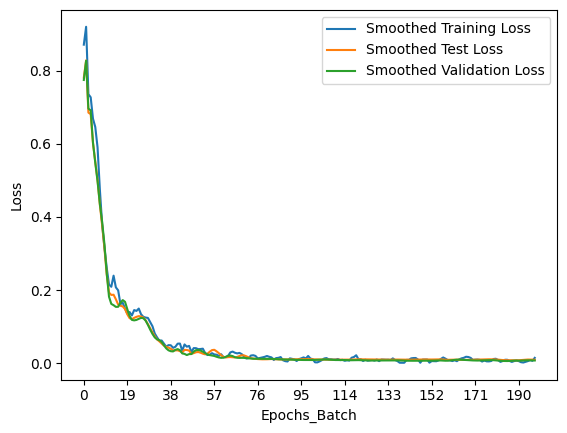

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经有了losses, test_losses, 和 valid_losses列表

window_size = 3  # 移动平均窗口大小
# 计算移动平均
smoothed_losses = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
smoothed_test_losses = np.convolve(test_losses, np.ones(window_size)/window_size, mode='valid')
smoothed_valid_losses = np.convolve(valid_losses, np.ones(window_size)/window_size, mode='valid')

# 绘制平滑后的曲线
plt.plot(smoothed_losses, label='Smoothed Training Loss')
plt.plot(smoothed_test_losses, label='Smoothed Test Loss')
plt.plot(smoothed_valid_losses, label='Smoothed Validation Loss')

# 设置横坐标刻度
num_ticks = 10  # 设置刻度数量
max_length = max(len(smoothed_losses), len(smoothed_test_losses), len(smoothed_valid_losses))
plt.xticks(range(0, max_length, max_length//num_ticks))

# 添加图例
plt.legend()

# 添加坐标轴标签
plt.xlabel('Epochs_Batch')  # 假设每个数据点代表一个批次的训练周期
plt.ylabel('Loss')

# 显示图表
plt.show()

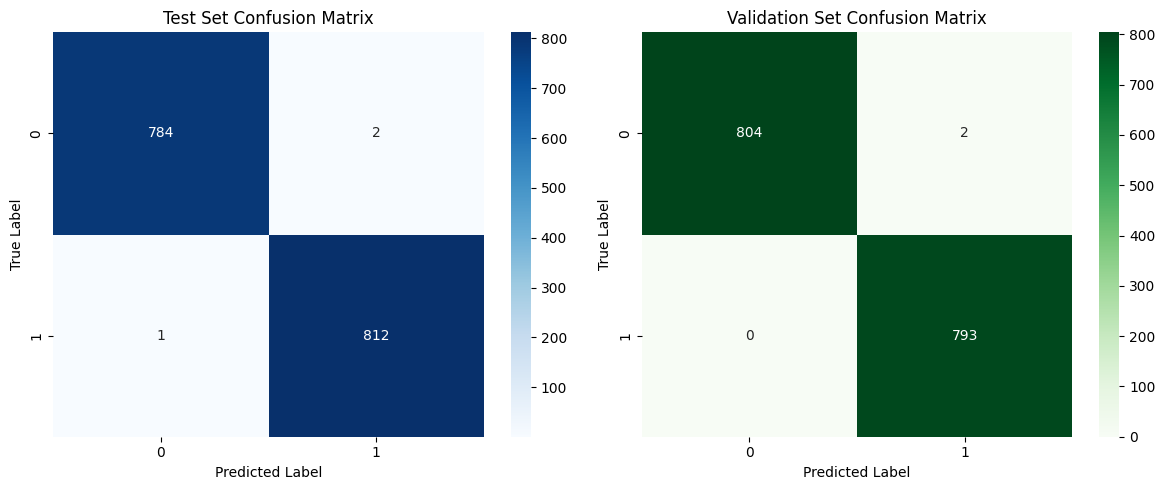

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 计算测试集和验证集的混淆矩阵
cm_test = confusion_matrix(test_Y, dd)  # 假设dd是测试集的预测结果
cm_valid = confusion_matrix(valid_Y, valid_dd)  # 假设valid_dd是验证集的预测结果

# 创建画布，定义子图布局
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 创建1行2列的子图

# 绘制测试集的混淆矩阵热力图
sns.heatmap(cm_test, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('Test Set Confusion Matrix')
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')

# 绘制验证集的混淆矩阵热力图
sns.heatmap(cm_valid, annot=True, fmt='d', ax=ax[1], cmap='Greens')
ax[1].set_title('Validation Set Confusion Matrix')
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')

# 显示图像
plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()

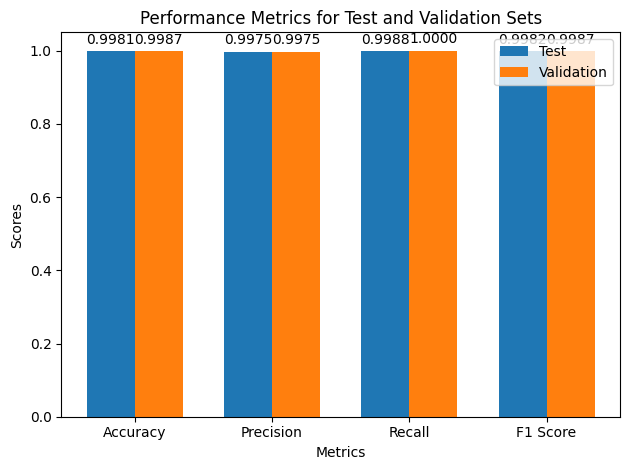

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 假设dd是测试集的预测结果，test_Y是测试集的真实标签
# 假设valid_dd是验证集的预测结果，valid_Y是验证集的真实标签

# 测试集性能指标
accuracy_test = accuracy_score(test_Y, dd)
precision_test = precision_score(test_Y, dd, average='binary')  
recall_test = recall_score(test_Y, dd, average='binary')
f1_test = f1_score(test_Y, dd, average='binary')

# 验证集性能指标
accuracy_valid = accuracy_score(valid_Y, valid_dd)
precision_valid = precision_score(valid_Y, valid_dd, average='binary')
recall_valid = recall_score(valid_Y, valid_dd, average='binary')
f1_valid = f1_score(valid_Y, valid_dd, average='binary')

# 性能指标
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
test_scores = [accuracy_test, precision_test, recall_test, f1_test]
valid_scores = [accuracy_valid, precision_valid, recall_valid, f1_valid]

# 设置图表位置
x = np.arange(len(metrics))
width = 0.35  # 条形图的宽度

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, test_scores, width, label='Test')
rects2 = ax.bar(x + width/2, valid_scores, width, label='Validation')

# 添加一些文本标签
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for Test and Validation Sets')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# 在条形图上显示数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


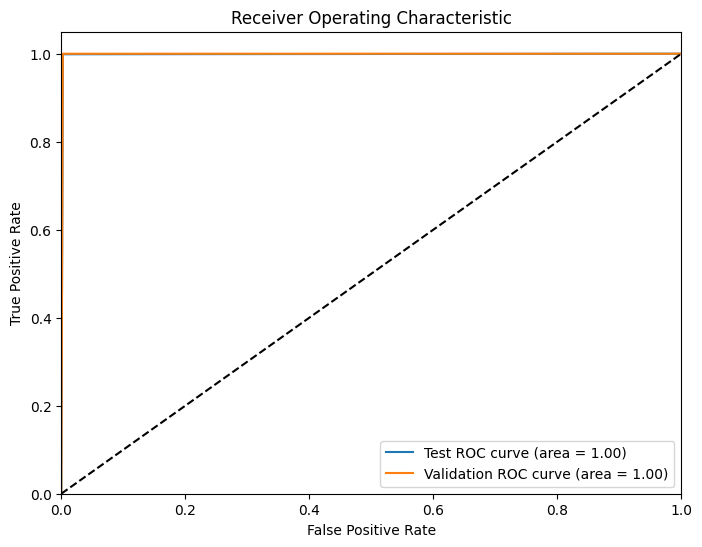

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 假设 dd 是测试集的预测概率，valid_dd 是验证集的预测概率
# test_Y 和 valid_Y 是相应的真实标签

# 测试集的ROC曲线和AUC
fpr_test, tpr_test, _ = roc_curve(test_Y, dd)
roc_auc_test = auc(fpr_test, tpr_test)

# 验证集的ROC曲线和AUC
fpr_valid, tpr_valid, _ = roc_curve(valid_Y, valid_dd)
roc_auc_valid = auc(fpr_valid, tpr_valid)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot(fpr_valid, tpr_valid, label=f'Validation ROC curve (area = {roc_auc_valid:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

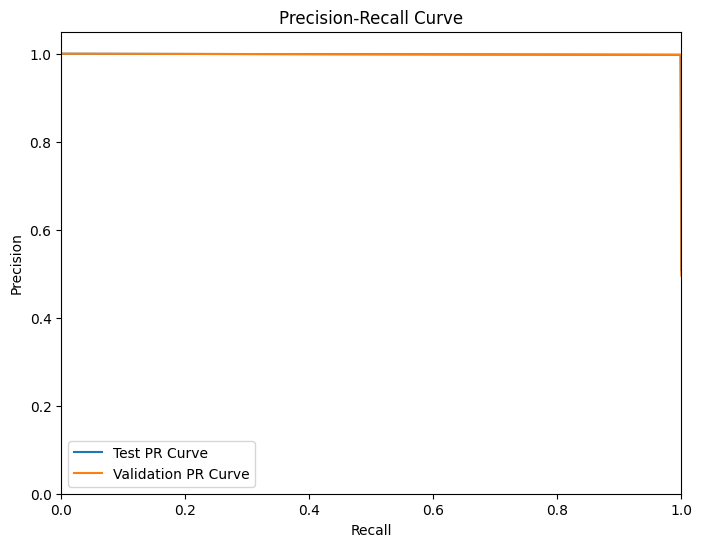

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# 计算测试集的精确率和召回率
precision_test, recall_test, _ = precision_recall_curve(test_Y, dd)

# 计算验证集的精确率和召回率
precision_valid, recall_valid, _ = precision_recall_curve(valid_Y, valid_dd)

# 绘制精确率-召回率曲线
plt.figure(figsize=(8, 6))
plt.plot(recall_test, precision_test, label='Test PR Curve')
plt.plot(recall_valid, precision_valid, label='Validation PR Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
